Bin's comment:

**NOT COMPLETED**

Last modified on 4/13

In [1]:
import math
import os
import random
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import glob
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import SimpleITK as sitk
import torch.optim as optim
from sklearn.metrics import classification_report

from UNet import UNet4, UNet3

In [2]:
class Config():
    batch_size = 16
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    epochs = 4
    warmup = 0.1
    lr = 1e-5
    T_0 = 100  # period of the first restart, we do not want it to restart, so we set it a big number
    T_mult = 1  # period multiplier, it does not matter
    eta_min = lr/10  # minimum learning rate
    len_train_dataloader = None
    len_valid_dataloader = None

In [3]:
# Set SEED here # to be completed

In [4]:
DATASET_PATH = 'dataset'
TRAIN_X_PATH = os.path.join(DATASET_PATH, 'X_train_input')
VALID_X_PATH = os.path.join(DATASET_PATH, 'X_test_input')
TRAIN_Y_PATH = os.path.join(DATASET_PATH, 'X_train_target')
VALID_Y_PATH = os.path.join(DATASET_PATH, 'X_test_target')

In [5]:
len_train = len(os.listdir(TRAIN_X_PATH))
Config.len_train_dataloader = len_train//Config.batch_size
len_train

35340

In [6]:
len_valid = len(os.listdir(VALID_X_PATH))
Config.len_valid_dataloader = len_valid//Config.batch_size
len_valid

8835

The index of TRAIN SET ranges from 0 to 35339 (end included)

The index of VALID SET ranges from 0 to 8834 (end included)

In [7]:
def image_loader(mode, x_or_y, index):
    """
    Return the numpy image given the information.
    mode: 'train', 'valid' or 'test'
    x_or_y: 'x' or 'y', 'x' stands for the input and 'y' stands for the target
    index: int, the index of the image
    """
    if mode == 'train':
        if x_or_y == 'x':
            filepath = os.path.join(TRAIN_X_PATH, os.path.basename(TRAIN_X_PATH)+'_'+str(index)+'.npy')
        if x_or_y == 'y':
            filepath = os.path.join(TRAIN_Y_PATH, os.path.basename(TRAIN_Y_PATH)+'_'+str(index)+'.npy')
    elif mode == 'valid':
        if x_or_y == 'x':
            filepath = os.path.join(VALID_X_PATH, os.path.basename(VALID_X_PATH)+'_'+str(index)+'.npy')
        if x_or_y == 'y':
            filepath = os.path.join(VALID_Y_PATH, os.path.basename(VALID_Y_PATH)+'_'+str(index)+'.npy')
    else:
        raise ValueError("The first or the second parameter is not valid")
        
    if not isinstance(index, int):
        raise TypeError("Index should be an integer")
    
    if mode == 'train' and (index < 0 or index > 35339):
            raise IndexError("Image index out of range 0 - 35339")
            
    if mode == 'valid' and (index < 0 or index > 8834):
            raise IndexError("Image index out of range 0 - 8834")
    
    return np.load(filepath)

In [8]:
img_example = image_loader('valid', 'y', 560)

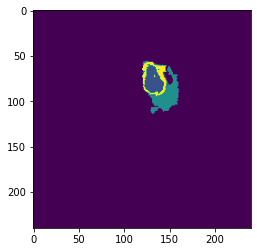

In [9]:
plt.imshow(img_example)

In [10]:
image_loader('train', 'y', 6164).shape

(240, 240)

In [11]:
image_loader('train', 'x', 6164).shape

(240, 240, 4)

**Bin's comment:**

SimpleITK is a widely used package to transform medical images


I dont know whether it is slower than other packages like torchvision transform
You may define other transformation functions and compare them

In [12]:
def transform(input_array, label_array):
    """
    Data augmentation for training set.
    input_array, label_array are in ndarray
    """
    return input_array, label_array

In [13]:
class TrainDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return len_train

    def __getitem__(self, idx):
        x, y = image_loader('train', 'x', idx), image_loader('train', 'y', idx)
        x = x.transpose((2, 0, 1))
        x, y = transform(x, y)
        return x, y # NOTE the permute, => Batch*Channel*Wright*Height
    
class ValidDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return len_valid

    def __getitem__(self, idx):
        x, y = image_loader('valid', 'x', idx), image_loader('valid', 'y', idx)
        x = x.transpose((2, 0, 1))
        return x,y

train_dataset = TrainDataset()
valid_dataset = ValidDataset()
train_dataloader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)

In [14]:
for inputs, targets in valid_dataloader:
    break

In [15]:
targets.shape

torch.Size([16, 240, 240])

In [16]:
#Test the model
net = UNet3(4, 5) # 4 channels, 5 classes (label 3 actually is ingored)
y = net(torch.randn(8,4,240,240))
_, y = torch.max(y, 1)
print(y.size())
del net, y

torch.Size([8, 240, 240])


In [ ]:
#The F1 score is the Dice coefficient of the set of retrieved items and the set of relevant items.

In [21]:
device=Config.device

model = UNet3(4,5)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=Config.lr)

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=Config.T_0, T_mult=Config.T_mult, eta_min=Config.eta_min)


for epoch in range(Config.epochs):
    print("Epoch "+str(epoch+1)+" start")
    model.train()
    train_bar = tqdm(total=Config.len_train_dataloader)

    for i, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.type(torch.LongTensor).to(device)

        optimizer.zero_grad()


        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        scheduler.step(epoch + i/len(train_dataloader))
        train_bar.update(1)
        break
        
    train_bar.close()

    model.eval()

    valid_bar = tqdm(total=Config.len_valid_dataloader)
    with torch.no_grad():
        valid_loss = 0.0
        total_pred = []
        total_target = []
        for j, (inputs, targets) in enumerate(valid_dataloader):
            inputs, targets = inputs.to(device), targets.type(torch.LongTensor).to(device)

            # forward
            outputs = model(inputs)
            result = torch.argmax(outputs.detach(), dim=1)
            loss = criterion(outputs, targets)
            pred_numpy=result.cpu().numpy().flatten().tolist()
            target_numpy=targets.cpu().numpy().flatten().tolist()
            total_pred.append(pred_numpy)
            total_target.append(target_numpy)
            valid_loss += loss.item()
            valid_bar.update(1)
        valid_loss /= (j + 1)
    valid_bar.close()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss:.4f}")
    print('------------------')

print('Training completed, generating the report, may takes minutes')
total_pred = np.concatenate(total_pred)
total_target = np.concatenate(total_target)
report = classification_report(total_target, total_pred, digits=3, target_names = ['Background', 'NCR/NET', 'ED', '-', 'ET'])
print(report)

Epoch 1 start


  0%|          | 0/2208 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

Epoch 1, Train Loss: 1.5427, Valid Loss: 1.5417


NameError: name 'y_true' is not defined

In [23]:
report = classification_report(total_target, total_pred, digits=3, target_names = ['Background', 'NCR/NET', 'ED', 'ET'])
# because class 3 actually does not appear, so we should not add it in the taget_names
print(report)

C:\Users\Liufenii\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Liufenii\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  Background      0.904     0.026     0.051 502465142
     NCR/NET      0.000     0.000     0.000   1632930
          ED      0.000     0.000     0.000   3624115
          ET      0.002     0.822     0.004   1173813

    accuracy                          0.028 508896000
   macro avg      0.227     0.212     0.014 508896000
weighted avg      0.893     0.028     0.050 508896000



C:\Users\Liufenii\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dice_list

In [ ]:
dice_list[0].shape

In [ ]:
result[2].numpy().shape

In [ ]:
targets[1].shape

In [ ]:
a = np.asarray([1,2,0])
b= np.asarray([2,4,0])
dice_coefficient(a,b)

In [ ]:
dice_for_each_class = np.sum([dice_coefficient(a,b), dice_coefficient(a,b)], axis=0)

In [ ]:
dice_for_each_class[0]

In [ ]:
c=torch.tensor([[1,2],[5,6]])
torch.argmax(c, axis=1)